In [47]:
import torch
import torch.nn as nn
import numpy as np

# Load data
data = np.load("hubbard_data_n6.npz")
U = 2.0  # example
x, psi_sq = data[f"U_{U}"]

# Normalize input
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
psi_sq_tensor = torch.tensor(psi_sq, dtype=torch.float32).view(-1, 1)

# PINN Model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

# Physics-Informed Loss
def hamiltonian_loss(x, psi_pred, t=1.0, U=2.0):
    psi_pred = psi_pred.view(-1)

    # First and second derivatives (finite diff)
    dx = x[1] - x[0]
    d2psi_dx2 = torch.zeros_like(psi_pred)
    d2psi_dx2[1:-1] = (psi_pred[2:] - 2*psi_pred[1:-1] + psi_pred[:-2]) / dx**2

    # Effective discrete Hamiltonian: −t d²ψ/dx² + U * n_up * n_down is simplified here
    H_psi = -t * d2psi_dx2  # kinetic term only
    E_pred = (H_psi * psi_pred).sum() / (psi_pred**2).sum()

    return ((H_psi - E_pred * psi_pred)**2).mean()
total_losses = []
data_losses = []
physics_losses = []
lam=0.8
# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    psi_pred = model(x_tensor)
    psi_sq_pred = psi_pred ** 2
    
    data_loss = mse(psi_sq_pred, psi_sq_tensor)
    phys_loss = hamiltonian_loss(x_tensor.squeeze(), psi_pred.squeeze(), t=1.0, U=U)
    
    scale_factor = phys_loss.item() / (data_loss.item() + 1e-8)  # Prevent div-by-zero
    data_loss = data_loss * scale_factor
    
    loss = (1-lam)*data_loss + lam * phys_loss
    loss.backward()
    optimizer.step()
    
    
    total_losses.append(loss.item())
    data_losses.append(data_loss.item())
    physics_losses.append(phys_loss.item())
    
#     if epoch % 500 == 0:
    print(f"Epoch {epoch} - Total Loss: {loss.item():.6f}, Data: {data_loss.item():.6f}, Physics: {phys_loss.item():.6f}")

# Final prediction
psi_final = model(x_tensor).detach().numpy().flatten()


Epoch 0 - Total Loss: 0.004563, Data: 0.004563, Physics: 0.004563
Epoch 1 - Total Loss: 0.003680, Data: 0.003680, Physics: 0.003680
Epoch 2 - Total Loss: 0.004236, Data: 0.004231, Physics: 0.004238
Epoch 3 - Total Loss: 0.003683, Data: 0.003673, Physics: 0.003685
Epoch 4 - Total Loss: 0.003575, Data: 0.003570, Physics: 0.003577
Epoch 5 - Total Loss: 0.003153, Data: 0.003145, Physics: 0.003155
Epoch 6 - Total Loss: 0.003108, Data: 0.003101, Physics: 0.003110
Epoch 7 - Total Loss: 0.003174, Data: 0.003164, Physics: 0.003176
Epoch 8 - Total Loss: 0.003143, Data: 0.003133, Physics: 0.003145
Epoch 9 - Total Loss: 0.003075, Data: 0.003065, Physics: 0.003078
Epoch 10 - Total Loss: 0.003018, Data: 0.003009, Physics: 0.003021
Epoch 11 - Total Loss: 0.003032, Data: 0.003022, Physics: 0.003034
Epoch 12 - Total Loss: 0.003157, Data: 0.003147, Physics: 0.003160
Epoch 13 - Total Loss: 0.003061, Data: 0.003050, Physics: 0.003063
Epoch 14 - Total Loss: 0.003148, Data: 0.003137, Physics: 0.003150
Epoch

Epoch 140 - Total Loss: 0.000895, Data: 0.000892, Physics: 0.000896
Epoch 141 - Total Loss: 0.000894, Data: 0.000891, Physics: 0.000895
Epoch 142 - Total Loss: 0.000837, Data: 0.000834, Physics: 0.000838
Epoch 143 - Total Loss: 0.000882, Data: 0.000879, Physics: 0.000883
Epoch 144 - Total Loss: 0.000861, Data: 0.000858, Physics: 0.000862
Epoch 145 - Total Loss: 0.000848, Data: 0.000845, Physics: 0.000849
Epoch 146 - Total Loss: 0.000835, Data: 0.000832, Physics: 0.000836
Epoch 147 - Total Loss: 0.000844, Data: 0.000842, Physics: 0.000845
Epoch 148 - Total Loss: 0.000831, Data: 0.000829, Physics: 0.000832
Epoch 149 - Total Loss: 0.000825, Data: 0.000823, Physics: 0.000826
Epoch 150 - Total Loss: 0.000849, Data: 0.000846, Physics: 0.000850
Epoch 151 - Total Loss: 0.000833, Data: 0.000830, Physics: 0.000834
Epoch 152 - Total Loss: 0.000871, Data: 0.000868, Physics: 0.000872
Epoch 153 - Total Loss: 0.000805, Data: 0.000802, Physics: 0.000806
Epoch 154 - Total Loss: 0.000737, Data: 0.000734

Epoch 263 - Total Loss: 0.000366, Data: 0.000364, Physics: 0.000366
Epoch 264 - Total Loss: 0.000355, Data: 0.000354, Physics: 0.000355
Epoch 265 - Total Loss: 0.000352, Data: 0.000351, Physics: 0.000352
Epoch 266 - Total Loss: 0.000359, Data: 0.000358, Physics: 0.000360
Epoch 267 - Total Loss: 0.000363, Data: 0.000362, Physics: 0.000364
Epoch 268 - Total Loss: 0.000353, Data: 0.000352, Physics: 0.000353
Epoch 269 - Total Loss: 0.000350, Data: 0.000349, Physics: 0.000351
Epoch 270 - Total Loss: 0.000349, Data: 0.000348, Physics: 0.000349
Epoch 271 - Total Loss: 0.000354, Data: 0.000353, Physics: 0.000354
Epoch 272 - Total Loss: 0.000348, Data: 0.000347, Physics: 0.000348
Epoch 273 - Total Loss: 0.000330, Data: 0.000329, Physics: 0.000330
Epoch 274 - Total Loss: 0.000323, Data: 0.000322, Physics: 0.000323
Epoch 275 - Total Loss: 0.000328, Data: 0.000327, Physics: 0.000329
Epoch 276 - Total Loss: 0.000342, Data: 0.000341, Physics: 0.000342
Epoch 277 - Total Loss: 0.000347, Data: 0.000346

Epoch 390 - Total Loss: 0.000210, Data: 0.000209, Physics: 0.000210
Epoch 391 - Total Loss: 0.000194, Data: 0.000194, Physics: 0.000194
Epoch 392 - Total Loss: 0.000189, Data: 0.000189, Physics: 0.000189
Epoch 393 - Total Loss: 0.000197, Data: 0.000196, Physics: 0.000197
Epoch 394 - Total Loss: 0.000187, Data: 0.000187, Physics: 0.000187
Epoch 395 - Total Loss: 0.000197, Data: 0.000197, Physics: 0.000197
Epoch 396 - Total Loss: 0.000191, Data: 0.000191, Physics: 0.000191
Epoch 397 - Total Loss: 0.000195, Data: 0.000195, Physics: 0.000196
Epoch 398 - Total Loss: 0.000190, Data: 0.000189, Physics: 0.000190
Epoch 399 - Total Loss: 0.000193, Data: 0.000192, Physics: 0.000193
Epoch 400 - Total Loss: 0.000187, Data: 0.000186, Physics: 0.000187
Epoch 401 - Total Loss: 0.000198, Data: 0.000197, Physics: 0.000198
Epoch 402 - Total Loss: 0.000205, Data: 0.000204, Physics: 0.000205
Epoch 403 - Total Loss: 0.000179, Data: 0.000179, Physics: 0.000179
Epoch 404 - Total Loss: 0.000185, Data: 0.000184

Epoch 515 - Total Loss: 0.000154, Data: 0.000154, Physics: 0.000155
Epoch 516 - Total Loss: 0.000162, Data: 0.000162, Physics: 0.000162
Epoch 517 - Total Loss: 0.000160, Data: 0.000159, Physics: 0.000160
Epoch 518 - Total Loss: 0.000158, Data: 0.000158, Physics: 0.000158
Epoch 519 - Total Loss: 0.000151, Data: 0.000151, Physics: 0.000151
Epoch 520 - Total Loss: 0.000150, Data: 0.000149, Physics: 0.000150
Epoch 521 - Total Loss: 0.000152, Data: 0.000152, Physics: 0.000152
Epoch 522 - Total Loss: 0.000148, Data: 0.000147, Physics: 0.000148
Epoch 523 - Total Loss: 0.000153, Data: 0.000152, Physics: 0.000153
Epoch 524 - Total Loss: 0.000153, Data: 0.000152, Physics: 0.000153
Epoch 525 - Total Loss: 0.000159, Data: 0.000159, Physics: 0.000159
Epoch 526 - Total Loss: 0.000161, Data: 0.000161, Physics: 0.000162
Epoch 527 - Total Loss: 0.000158, Data: 0.000157, Physics: 0.000158
Epoch 528 - Total Loss: 0.000150, Data: 0.000150, Physics: 0.000150
Epoch 529 - Total Loss: 0.000143, Data: 0.000143

Epoch 639 - Total Loss: 0.000113, Data: 0.000112, Physics: 0.000113
Epoch 640 - Total Loss: 0.000112, Data: 0.000111, Physics: 0.000112
Epoch 641 - Total Loss: 0.000107, Data: 0.000106, Physics: 0.000107
Epoch 642 - Total Loss: 0.000111, Data: 0.000111, Physics: 0.000111
Epoch 643 - Total Loss: 0.000113, Data: 0.000112, Physics: 0.000113
Epoch 644 - Total Loss: 0.000108, Data: 0.000107, Physics: 0.000108
Epoch 645 - Total Loss: 0.000106, Data: 0.000105, Physics: 0.000106
Epoch 646 - Total Loss: 0.000111, Data: 0.000110, Physics: 0.000111
Epoch 647 - Total Loss: 0.000107, Data: 0.000107, Physics: 0.000107
Epoch 648 - Total Loss: 0.000105, Data: 0.000104, Physics: 0.000105
Epoch 649 - Total Loss: 0.000103, Data: 0.000102, Physics: 0.000103
Epoch 650 - Total Loss: 0.000104, Data: 0.000104, Physics: 0.000104
Epoch 651 - Total Loss: 0.000107, Data: 0.000107, Physics: 0.000107
Epoch 652 - Total Loss: 0.000101, Data: 0.000100, Physics: 0.000101
Epoch 653 - Total Loss: 0.000097, Data: 0.000096

Epoch 767 - Total Loss: 0.000051, Data: 0.000051, Physics: 0.000051
Epoch 768 - Total Loss: 0.000051, Data: 0.000051, Physics: 0.000051
Epoch 769 - Total Loss: 0.000047, Data: 0.000046, Physics: 0.000047
Epoch 770 - Total Loss: 0.000049, Data: 0.000049, Physics: 0.000049
Epoch 771 - Total Loss: 0.000050, Data: 0.000050, Physics: 0.000050
Epoch 772 - Total Loss: 0.000053, Data: 0.000053, Physics: 0.000053
Epoch 773 - Total Loss: 0.000046, Data: 0.000046, Physics: 0.000046
Epoch 774 - Total Loss: 0.000048, Data: 0.000048, Physics: 0.000049
Epoch 775 - Total Loss: 0.000048, Data: 0.000048, Physics: 0.000048
Epoch 776 - Total Loss: 0.000046, Data: 0.000046, Physics: 0.000046
Epoch 777 - Total Loss: 0.000046, Data: 0.000045, Physics: 0.000046
Epoch 778 - Total Loss: 0.000046, Data: 0.000046, Physics: 0.000046
Epoch 779 - Total Loss: 0.000044, Data: 0.000044, Physics: 0.000044
Epoch 780 - Total Loss: 0.000047, Data: 0.000047, Physics: 0.000047
Epoch 781 - Total Loss: 0.000047, Data: 0.000046

Epoch 889 - Total Loss: 0.000044, Data: 0.000044, Physics: 0.000044
Epoch 890 - Total Loss: 0.000038, Data: 0.000038, Physics: 0.000038
Epoch 891 - Total Loss: 0.000039, Data: 0.000039, Physics: 0.000039
Epoch 892 - Total Loss: 0.000039, Data: 0.000039, Physics: 0.000039
Epoch 893 - Total Loss: 0.000040, Data: 0.000040, Physics: 0.000040
Epoch 894 - Total Loss: 0.000036, Data: 0.000036, Physics: 0.000036
Epoch 895 - Total Loss: 0.000038, Data: 0.000038, Physics: 0.000038
Epoch 896 - Total Loss: 0.000038, Data: 0.000038, Physics: 0.000038
Epoch 897 - Total Loss: 0.000037, Data: 0.000036, Physics: 0.000037
Epoch 898 - Total Loss: 0.000037, Data: 0.000037, Physics: 0.000037
Epoch 899 - Total Loss: 0.000038, Data: 0.000038, Physics: 0.000038
Epoch 900 - Total Loss: 0.000037, Data: 0.000037, Physics: 0.000037
Epoch 901 - Total Loss: 0.000039, Data: 0.000039, Physics: 0.000039
Epoch 902 - Total Loss: 0.000037, Data: 0.000037, Physics: 0.000037
Epoch 903 - Total Loss: 0.000040, Data: 0.000040

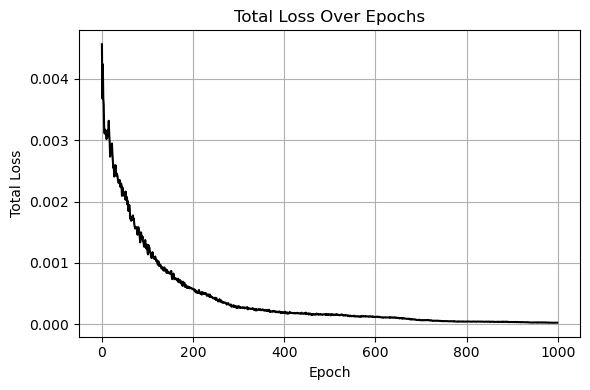

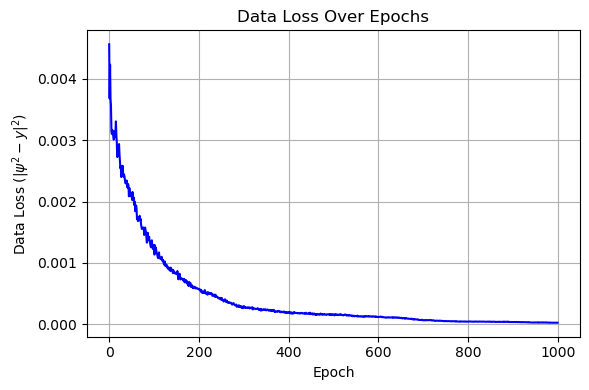

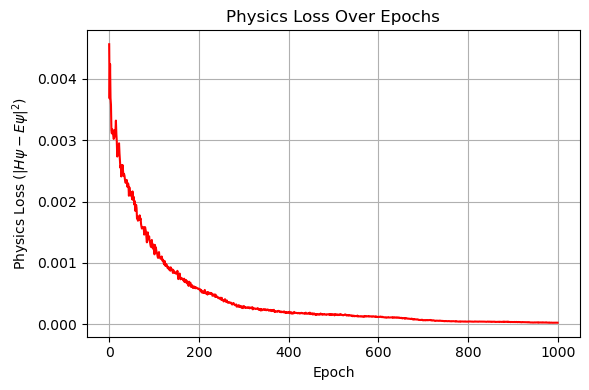

In [48]:
import matplotlib.pyplot as plt

# === 1. Total Loss Plot ===
plt.figure(figsize=(6, 4))
plt.plot(total_losses, color='black')
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Total Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Data Loss Plot ===
plt.figure(figsize=(6, 4))
plt.plot(data_losses, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Data Loss ($\\|\\psi^2 - y\\|^2$)")
plt.title("Data Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Physics Loss Plot ===
plt.figure(figsize=(6, 4))
plt.plot(physics_losses, color='red')
plt.xlabel("Epoch")
plt.ylabel("Physics Loss ($\\|H\\psi - E\\psi\\|^2$)")
plt.title("Physics Loss Over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
from sklearn.metrics import r2_score
import torch.nn.functional as F

with torch.no_grad():
    psi_pred = model(x_tensor)
    psi_sq_pred = (psi_pred ** 2).squeeze()

# Normalize both distributions to sum to 1
true_dist = psi_sq_tensor.squeeze()
pred_dist = psi_sq_pred

true_dist /= true_dist.sum()
pred_dist /= pred_dist.sum()

# Add small epsilon to avoid log(0)
epsilon = 1e-10
true_dist = true_dist + epsilon
pred_dist = pred_dist + epsilon

# KL Divergence (P || Q): KL(true || pred)
kl_div = F.kl_div(pred_dist.log(), true_dist, reduction='batchmean').item()

# R^2 Score
r2 = r2_score(true_dist.numpy(), pred_dist.numpy())

print(f"KL Divergence: {kl_div:.6f}")
print(f"R^2 Score: {r2:.6f}")

KL Divergence: 0.000860
